In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn.utils as utils

## 1. Preparation

In [2]:
# Load the data
df = pd.read_csv('hourly_trip_counts.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort data by date and hour
df = df.sort_values(by=['date', 'hour']).reset_index(drop=True)

# Normalize the count values
scaler = MinMaxScaler()
df['count'] = scaler.fit_transform(df['count'].values.reshape(-1, 1))

In [3]:
# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24  # Sequence length, here we choose 24h
data = df['count'].values
X, y = create_sequences(data, SEQ_LENGTH)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# Reshape tensors for LSTM input (batch_size, seq_length, num_features)
""" 
Unsquee turn a tensor by adding an extra dimension of depth 1, note that the number of dim
"""
X_train_tensor = X_train_tensor.unsqueeze(-1)
X_test_tensor = X_test_tensor.unsqueeze(-1)

# Display data shapes
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([6988, 24, 1]),
 torch.Size([6988]),
 torch.Size([1747, 24, 1]),
 torch.Size([1747]))

## 2. Define the MDN part

Define the MDN layer

In [4]:

class MDNLayer(nn.Module):
    def __init__(self, input_dim, output_dim, num_gaussians):
        super(MDNLayer, self).__init__()
        self.num_gaussians = num_gaussians

        # Establish three fully connected layers from input_dim to num_gaussians
        # Caculate the weights of the mixture of Gaussian distribution
        self.z_pi = nn.Linear(input_dim, num_gaussians)
        self.z_sigma = nn.Linear(input_dim, num_gaussians * output_dim) # Here actually output_dim is 1 beacuse it is the dimension of each Gaussian distribution ouput
        self.z_mu = nn.Linear(input_dim, num_gaussians * output_dim)

    # Here the keyword self in python is used to represent the instance of the class. It allow you to access attributes and methods of the class in object-oriented programming.
    # General Explanation of self: self is used to refer to the current instance of the class / By useing self, you can accsee other access other methods and attributes with the same class.
    def forward(self, x):
        # The softmax function is used to convert a vector of valuse into a probability distribution, where the sum of all probabilities is 
        pi = F.softmax(self.z_pi(x), dim=1) # dim=1 is because we ensure that the softmax funtion is applied independently to each sample in the batch.
        sigma = torch.exp(self.z_sigma(x)) # this ensures that the output standard sigman is always postive.
        mu = self.z_mu(x)

        
        return pi, sigma, mu

Below is the expecation-maximum algorithm. We need calculate the posterior probability ('responsibility') of each data point $x_i$ coming from each Gaussian component $k$ 

$$\gamma\left(z_{i k}\right)=\frac{\pi_k \mathcal{N}\left(x_i \mid \mu_k, \sigma_k^2\right)}{\sum_{j=1}^K \pi_j \mathcal{N}\left(x_i \mid \mu_j, \sigma_j^2\right)}$$

Here, $z_{i k}$ is a latent variable indicating whether data point $x_i$ was generated by the $k$-th Gaussian component. $\gamma\left(z_{i k}\right)$ essentially is the expected value of $z_{i k}$.



Then we use log-probability to calculate. This is crucial for enhancing numerical stability and simplifying computational processes, particularly when dealing with real datasets. Utilizing log probabilities ensures the algorithm remains stable under various data condition, avoiding numercial issues caused by extremely small probabilities value. This method is essential for ensuring the robust performance of the algorithm across diverse data scenarios.

In [5]:
def e_step(pi, sigma, mu, xi):   
    sigma = torch.clamp(sigma, min=1e-6)
    m =torch.distributions.Normal(mu, sigma)
    xi = xi.unsqueeze(1).expand_as(mu) # Transform y to have the shape (batch_size, num_gaussians)
    log_prob = m.log_prob(xi)
    log_pi = torch.log(pi)
    log_responsibilites = log_prob + log_pi
    log_sum = torch.logsumexp(log_responsibilites, dim=1, keepdim=True) # dim=1 is to computes across each point's Gaussian components, and then keeps the dimension for broadcasting for broadcasting in subsequent operations
    responsibilites = torch.exp(log_responsibilites - log_sum)
    return responsibilites # The shape is (batch_size, num_gaussians)

$$\begin{gathered}\mu_k=\frac{\sum_{i=1}^n \gamma\left(z_{i k}\right) x_i}{\sum_{i=1}^n \gamma\left(z_{i k}\right)} \\ \sigma_k^2=\frac{\sum_{i=1}^n \gamma\left(z_{i k}\right)\left(x_i-\mu_k\right)^2}{\sum_{i=1}^n \gamma\left(z_{i k}\right)}\end{gathered}$$

$$\pi_k=\frac{1}{n} \sum_{i=1}^n \gamma\left(z_{i k}\right)$$

In [6]:
def m_step(responsibilites, xi, num_gaussians):
    """ 
    xi.unsqueeze(1) transforms the original data xi (assumed to have a shape of [n_samples]) into a shape of [n_samples, 1]. 
    This transformation is done to make it compatible for element-wise multiplication with responsibilities, which has a shape of [n_samples, num_gaussians]

    responsibilities * xi.unsqueeze(1) calculates each data point's contribution to each Gaussian component, i.e., the weighting. Here, each data point x[i] is expanded to match the size of responsibilities[i], and then multiplied element-wise. 
    The result is the weighted contribution of each sample to each Gaussian component
    """

    weighted_sum = torch.sum(responsibilites * xi.unsqueeze(1), dim=0)
    sum_responsibilities = torch.sum(responsibilites, dim=0)
    new_mu = weighted_sum / sum_responsibilities

    xi_mu = xi.unsqueeze(1) - new_mu
    weighted_xi_mu = responsibilites * (xi_mu ** 2)
    new_sigma = torch.sqrt(torch.sum(weighted_xi_mu, dim=0) / sum_responsibilities)
    new_sigma = torch.clamp(new_sigma, min=1e-6)  

    new_pi = sum_responsibilities / responsibilites.size(0)
    return new_pi, new_sigma, new_mu

**LSTMMDN  Model**

In [7]:
# Modify the LSTM model
class LSTMMDNModel(nn.Module):
    # Here the number of Gaussians determines the flexibility of the model in representing complex distributions.Generally, more Gaussians allow the model to fit more complex and multimodel distribution
    def __init__(self, input_size=1, output_size=1, num_gaussians=10): 
        super(LSTMMDNModel, self).__init__()
        
        self.num_gaussians = num_gaussians
        self.hidden_layer_size = 128
        # The input and output tensor provided to the model will have the format like 'shape(batch, seq, feature)'
        self.lstm = nn.LSTM(input_size, self.hidden_layer_size, num_layers=2, batch_first=True, dropout=0.1)
        self.mdn = MDNLayer(self.hidden_layer_size, output_size, num_gaussians)


    def forward(self, input_seq):

        # When an lstm processes an input sequence, it outputs a tensor that contains the hidden states for each timestep in the sequence. 
        # The output tensor has the shape (batch_size, sequence_length, hidden_layer_size)
        batch_size = input_seq.size(0)
        h_0 = torch.zeros(2, batch_size, self.hidden_layer_size).to(input_seq.device)
        c_0 = torch.zeros(2, batch_size, self.hidden_layer_size).to(input_seq.device)
        
        lstm_out, _ = self.lstm(input_seq, (h_0, c_0))

        lstm_out = lstm_out[:, -1, :] # We choose the hidden state of the last time step for each sequence in the batch, which summerize representation of the entire input sequence
        pi, sigma, mu = self.mdn(lstm_out)
        return pi, sigma, mu


**Define the MDN loss funtion**

The loss function is implementing a form of the negative log_likelihood loss for a mixture of Gaussian distribution. This approach measures how well the predicted probability distribution explains the observed data points.

In [8]:
def mdn_loss(pi, sigma, mu, y):
    sigma = torch.clamp(sigma, min=1e-6) # avoid sigma equals 0
    m = torch.distributions.Normal(loc=mu, scale=sigma) # This code creates a set of normal distribution parameterized by mu and sigma
    y = y.unsqueeze(1).expand(y.size(0), 10)  # Transform y to have the shape ((batch_size, num_gaussians, num_gaussians * output_dim))

    #Here we use a numerically stable computation method when calculating sum of exponential. 
    loss = torch.logsumexp(torch.log(pi) + m.log_prob(y), dim=1)  # shape (batch_size, output_size)
    return -torch.mean(loss)


In [9]:
# Create the dataset and dataloader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # Randomly shuffle the data at the beginning of each training cycle (epoch), avoiding overfitting during training

# Initialize the model, the loss function and optimizer

model = LSTMMDNModel()

# Here the learning rate is 0.001
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Set the number of epochs
epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for seq, label in data_loader:
        optimizer.zero_grad()  # 清除旧的梯度

        pi, sigma, mu = model(seq)  # 现在 forward 方法会自动调整隐藏状态大小

        responsibilities = e_step(pi, sigma, mu, label)
        new_pi, new_sigma, new_mu = m_step(responsibilities, label, model.num_gaussians)

        if torch.isnan(new_pi).any() or torch.isnan(new_sigma).any() or torch.isnan(new_mu).any():
            print("NaN values found in new_pi, new_sigma, or new_mu")
            break

        loss = mdn_loss(new_pi, new_sigma, new_mu, label)
        # After loss.backward()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  # 更新所有参数

        train_loss += loss.item() * batch_size

    train_losses.append(train_loss / len(X_train_tensor))

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Train Loss: {train_losses[-1]}')

print(f'Final Train Loss: {train_losses[-1]}')


Epoch 0 Train Loss: -0.021585225820131962
Epoch 10 Train Loss: -0.2488058368069278
Epoch 20 Train Loss: -0.2465187175722892
Epoch 30 Train Loss: -0.25002493773724055
Epoch 40 Train Loss: -0.31142216378371923
Final Train Loss: -0.30580845449608124


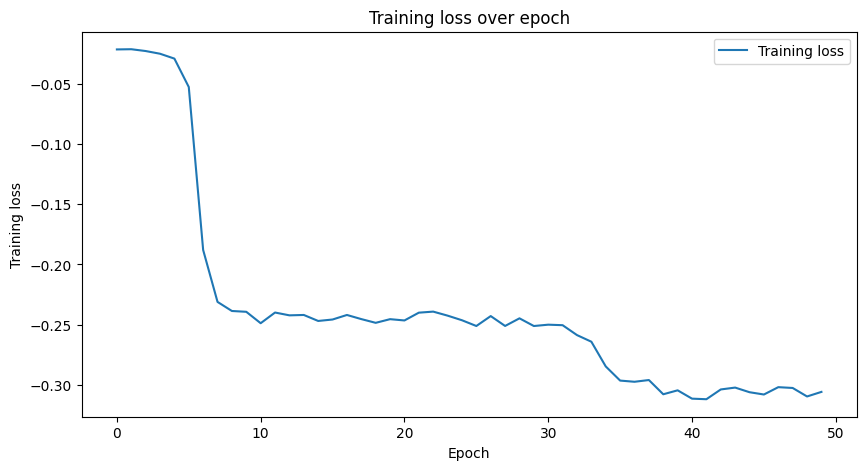

In [15]:
# Visualize the training loss

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss over epoch')
plt.legend()
plt.show()

Index 2, Loss: 1.0938698053359985
Pi: tensor([[0.0122, 0.0500, 0.0053, 0.0481, 0.1205, 0.0059, 0.6719, 0.0165, 0.0606,
         0.0092]]), Sigma: tensor([[15.1600,  0.2423, 13.9011,  0.0977,  0.1167, 22.5884,  0.0291, 13.7912,
          0.2193, 11.4001]]), Mu: tensor([[ 2.2831, -1.5582,  2.4474,  0.0454, -0.9053,  1.6869,  0.0388,  2.0292,
         -1.1207,  2.1135]])
Index 3, Loss: 3.0756750106811523
Pi: tensor([[0.0122, 0.0500, 0.0053, 0.0481, 0.1205, 0.0059, 0.6719, 0.0165, 0.0606,
         0.0092]]), Sigma: tensor([[15.1604,  0.2423, 13.9020,  0.0977,  0.1167, 22.5897,  0.0291, 13.7906,
          0.2192, 11.4009]]), Mu: tensor([[ 2.2831, -1.5582,  2.4474,  0.0453, -0.9053,  1.6869,  0.0388,  2.0292,
         -1.1207,  2.1135]])
Index 4, Loss: 5.765158653259277
Pi: tensor([[0.0122, 0.0499, 0.0053, 0.0481, 0.1205, 0.0059, 0.6719, 0.0165, 0.0606,
         0.0092]]), Sigma: tensor([[15.1635,  0.2423, 13.9049,  0.0977,  0.1167, 22.5952,  0.0291, 13.7912,
          0.2192, 11.4026]]), Mu

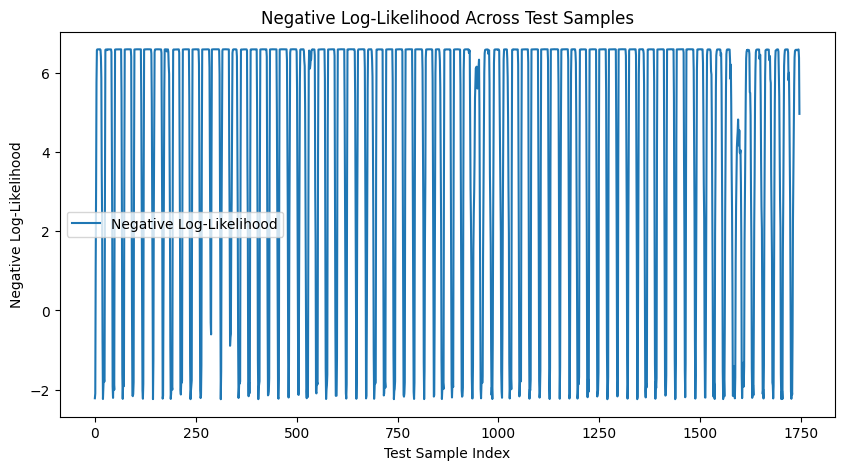

In [16]:
# Calculating negative log-likelihood for the test set
nll_losses = []
model.eval()
with torch.no_grad():
    for i in range(len(X_test_tensor)):
        seq = X_test_tensor[i:i+1]
        label = y_test_tensor[i:i+1]
        
        pi, sigma, mu = model(seq)
        loss = mdn_loss(pi, sigma, mu, label)

        if loss.item() > 0:
            print(f"Index {i}, Loss: {loss.item()}")
            print(f"Pi: {pi}, Sigma: {sigma}, Mu: {mu}")
            
        nll_losses.append(loss.item())

average_nll_loss = sum(nll_losses) / len(nll_losses)
print(f'Average Negative Log-Likelihood on Test Set: {average_nll_loss}')

plt.figure(figsize=(10, 5))
plt.plot(nll_losses, label='Negative Log-Likelihood')
plt.xlabel('Test Sample Index')
plt.ylabel('Negative Log-Likelihood')
plt.title('Negative Log-Likelihood Across Test Samples')
plt.legend()
plt.show()

In [17]:
percentage = sum(1 for x in nll_losses if x >= 0) / len(nll_losses)
percentage

0.819118488838008

In [13]:
# # Saving the Model

# # Specify the path to save the model
# model_save_path = 'lstm_model.pth'

# # Save the model's state dictionary
# torch.save(model.state_dict(), model_save_path)


In [14]:
# import torch

# # Initialize the model (make sure the model class definition is available)
# model = LSTMModel()

# # Load the model's state dictionary
# model_load_path = 'lstm_model.pth'
# model.load_state_dict(torch.load(model_load_path))

# # Set the model to evaluation mode
# model.eval()
